# Giai đoạn 4 (V3) – Thêm ORB (Full 5 đặc trưng)

In [6]:
import cv2, os, re, numpy as np
from skimage.metrics import structural_similarity as ssim
import pytesseract
from difflib import SequenceMatcher
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold  
from sklearn.metrics import classification_report, confusion_matrix

pytesseract.pytesseract.tesseract_cmd = r'D:\Apps\Tesseract-OCR\tesseract.exe'

def load_cases():
    mapping = {'identical':'similar','text_changes':'almost','layout_changes':'almost',
               'changes':'different','completely_different':'different'}
    cases, groups = [], []
    ori_dir = "Pictures_VisualTesting/original_image/"
    var_dir = "Pictures_VisualTesting/variant_image/"

    for f in os.listdir(ori_dir):
        m = re.search(r'original_(\d+)', f)
        if not m: continue
        group_id = int(m.group(1))
        vidir = os.path.join(var_dir, f"original_{m.group(1)}")
        if not os.path.isdir(vidir): continue
        for vf in os.listdir(vidir):
            label = mapping.get(vf.split('.')[0].lower())
            if label: 
                cases.append((os.path.join(ori_dir,f), os.path.join(vidir,vf), label))
                groups.append(group_id)
    return cases, groups

class FeatureSVM:
    def __init__(self, C = 5.0, kernel = 'linear', gamma = 'scale'):
        self.scaler = StandardScaler()
        self.model = SVC(
            kernel = kernel,
            C = C,
            gamma = gamma,
            class_weight = 'balanced',
            random_state = 42
        )
        
        self.orbs = cv2.ORB_create(nfeatures=150)
        self.map = {'similar': 0, 'almost': 1, 'different': 2}
        self.names = ['Similar', 'Almost', 'Different']
        self._ocr_cache = {}

    def prep_gray(self, img):
        g = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        if g is None: return None
        max_pixels = 700_000
        h, w = g.shape
        if h * w > max_pixels:
            s = (max_pixels / (h * w)) ** 0.5
            g = cv2.resize(g, (int(w * s), int(h * s)))
        g = cv2.medianBlur(g, 3)
        return g
    
    def ensure_same_size(self, g1, g2):
        if g1 is None or g2 is None: return None, None
        if g1.shape == g2.shape: return g1, g2
        h1, w1 = g1.shape
        g2 = cv2.resize(g2, (w1, h1))  
        return g1, g2

    def ssim(self, a, b):
        try:
            g1 = self.prep_gray(a)
            g2 = self.prep_gray(b)
            g1, g2 = self.ensure_same_size(g1, g2)
            if g1 is None or g2 is None: return 0.5
            return ssim(g1, g2, data_range=255)
        except: return 0.5

    def ocr(self,a,b):
        def get_words(p, gimg):
            if p in self._ocr_cache: return self._ocr_cache[p]
            bw = cv2.adaptiveThreshold(gimg,255,cv2.ADAPTIVE_THRESH_MEAN_C,
                                       cv2.THRESH_BINARY,21,8)
            text = pytesseract.image_to_string(bw, config="--oem 3 --psm 6")
            ws = re.sub(r'[^A-Za-z0-9 ]+',' ', text).lower().split()
            self._ocr_cache[p]=ws
            return ws
        try:
            g1 = self.prep_gray(a)
            g2 = self.prep_gray(b)
            if g1 is None or g2 is None: return 0.5
            t1 = get_words(a, g1)
            t2 = get_words(b, g2)
            if len(t1) < 3 and len(t2) < 3: return 0.8
            if len(t1) == 0 or len(t2) == 0: return 0.3
            sm = SequenceMatcher(None, ' '.join(t1), ' '.join(t2)).ratio()
            jacc = len(set(t1) & set(t2)) / max(len(set(t1)), len(set(t2)))
            return float(np.clip(0.7 * sm + 0.3 * jacc, 0.1, 0.95))
        except: return 0.5

    def hist(self, a, b):
        try:
            c1 = cv2.imread(a)
            c2 = cv2.imread(b)
            if c1 is None or c2 is None: return 0.5
            bins = 32
            vals = []
            for ch in range(3):
                h1 = cv2.calcHist([c1], [ch], None, [bins], [0, 256])
                h2 = cv2.calcHist([c2], [ch], None, [bins], [0, 256])
                cv2.normalize(h1, h1, alpha=1.0, norm_type=cv2.NORM_L1)
                cv2.normalize(h2, h2, alpha=1.0, norm_type=cv2.NORM_L1)
                vals.append((cv2.compareHist(h1, h2, cv2.HISTCMP_CORREL) + 1) / 2)
            return float(np.mean(vals))
        except: return 0.5

    def orb(self, a, b):
        try:
            g1 = self.prep_gray(a)
            g2 = self.prep_gray(b)
            kp1, d1 = self.orbs.detectAndCompute(g1, None)
            kp2, d2 = self.orbs.detectAndCompute(g2, None)
            if d1 is None or d2 is None: return 0.5
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
            knn = bf.knnMatch(d1, d2, k=2)
            good = []
            for pr in knn:
                if len(pr) < 2: continue
                m, n = pr
                if m.distance < 0.75 * n.distance: good.append(m)
            if not good: return 0.5
            ratio = len(good) / max(1, min(len(kp1), len(kp2)))
            quality = 1 - np.mean([m.distance for m in good]) / 256.0
            return float(np.clip(0.5 * ratio + 0.5 * quality, 0, 1))
        except: return 0.5

    def layout(self, a, b):
        try:
            g1 = self.prep_gray(a)
            g2 = self.prep_gray(b)
            g1, g2 = self.ensure_same_size(g1, g2)
            if g1 is None or g2 is None: return 0.5
            e1 = cv2.Canny(g1, 50, 150) > 0
            e2 = cv2.Canny(g2, 50, 150) > 0
            inter = np.logical_and(e1, e2).sum()
            uni = np.logical_or(e1, e2).sum()
            if uni == 0: return 1.0
            return float(inter/uni)
        except: return 0.5

    def feat(self,a,b):
        return [self.ssim(a,b), self.ocr(a,b), self.hist(a,b), self.orb(a,b), self.layout(a,b)]

    def train_eval(self, cases, groups):
        X = [self.feat(a,b) for a,b,l in cases]
        y = [self.map[l] for _,_,l in cases]
        
        gkf = GroupKFold(n_splits=5)
        accuracies = []
        fold = 1
        
        for train_idx, test_idx in gkf.split(X, y, groups):
            Xtr = [X[i] for i in train_idx]
            ytr = [y[i] for i in train_idx]
            Xte = [X[i] for i in test_idx]
            yte = [y[i] for i in test_idx]
            
            self.scaler.fit(Xtr)
            self.model.fit(self.scaler.transform(Xtr), ytr)
            yp = self.model.predict(self.scaler.transform(Xte))

            acc = (yp==yte).mean()*100
            accuracies.append(acc)
            
            print(f"\nFold {fold} - SVM: {acc:.1f}%")
            print(classification_report(yte, yp, target_names=self.names))
            print(confusion_matrix(yte, yp))
            fold += 1

        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        
        print(f"Mean Accuracy: {mean_acc:.1f}%")
        print(f"Std Accuracy: {std_acc:.1f}%")
        
        return mean_acc, std_acc

cases, groups = load_cases()
print(f"{len(cases)} cases from {len(set(groups))} groups")
default_svm = FeatureSVM()  
svm_mean, svm_std = default_svm.train_eval(cases, groups)

300 cases from 60 groups

Fold 1 - SVM: 95.0%
              precision    recall  f1-score   support

     Similar       1.00      1.00      1.00        12
      Almost       1.00      0.88      0.93        24
   Different       0.89      1.00      0.94        24

    accuracy                           0.95        60
   macro avg       0.96      0.96      0.96        60
weighted avg       0.96      0.95      0.95        60

[[12  0  0]
 [ 0 21  3]
 [ 0  0 24]]

Fold 2 - SVM: 90.0%
              precision    recall  f1-score   support

     Similar       1.00      1.00      1.00        12
      Almost       0.88      0.88      0.88        24
   Different       0.88      0.88      0.88        24

    accuracy                           0.90        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.90      0.90      0.90        60

[[12  0  0]
 [ 0 21  3]
 [ 0  3 21]]

Fold 3 - SVM: 93.3%
              precision    recall  f1-score   support

     Similar       0.

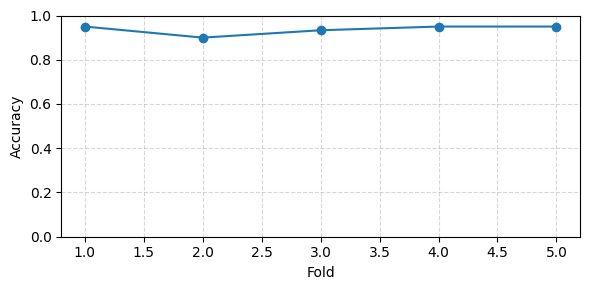

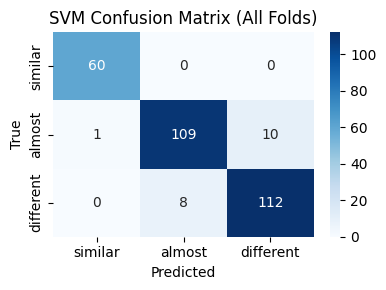

In [7]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score

def build_feature_df(feat_extractor, cases, groups):
    rows = []
    for (a,b,l), g in zip(cases, groups):
        f = feat_extractor.feat(a,b)
        cols = ['SSIM','OCR','Hist','ORB','Layout'] if len(f)==5 else \
               ['SSIM','OCR','Hist','Layout'] if len(f)==4 else \
               ['SSIM','Hist','Layout'] if len(f)==3 else ['SSIM']
        row = {c:v for c,v in zip(cols,f)}
        row['label'] = l
        row['group'] = g
        rows.append(row)
    return pd.DataFrame(rows)

if 'df_svm' not in globals():
    df_svm = build_feature_df(default_svm, [(a,b,l) for a,b,l in cases], groups)
label_order = ['similar','almost','different']
feat_cols = ['SSIM','OCR','Hist','ORB','Layout']

gkf = GroupKFold(n_splits=5)
X_all = df_svm[feat_cols].values
y_all = df_svm['label'].values
accs=[]; all_true=[]; all_pred=[]

for fold,(tr,te) in enumerate(gkf.split(X_all, y_all, groups),1):
    Xtr,Xte = X_all[tr], X_all[te]
    ytr, yte = y_all[tr], y_all[te]

    ytr_int = [default_svm.map[l] for l in ytr]
    default_svm.scaler.fit(Xtr)
    default_svm.model.fit(default_svm.scaler.transform(Xtr), ytr_int)
    yp_int = default_svm.model.predict(default_svm.scaler.transform(Xte))
    inv_map = {v:k for k,v in default_svm.map.items()}
    yp = [inv_map[i] for i in yp_int]
    accs.append(accuracy_score(yte, yp))
    all_true.extend(yte); all_pred.extend(yp)

plt.figure(figsize=(6,3))
plt.plot(range(1,len(accs)+1), accs, marker='o')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0,1); plt.grid(ls='--',alpha=.5)
plt.tight_layout()
plt.show()

cm = confusion_matrix(all_true, all_pred, labels=label_order)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_order, yticklabels=label_order)
plt.title('SVM Confusion Matrix (All Folds)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.svm import SVC
import pandas as pd
import numpy as np

X = [default_svm.feat(a,b) for a,b,l in cases]
y = [default_svm.map[l] for _,_,l in cases]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(class_weight='balanced', random_state=42))
])

param_grid = {
    'model__kernel': ['rbf','linear'],
    'model__C': [0.5,1,2,5,7,10],
    'model__gamma': ['scale','auto',0.05,0.1,1.0]  
}

cv = GroupKFold(n_splits=5)
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    refit=True
)

gs.fit(X, y, groups=groups)

best_params = gs.best_params_
print("Best params (inner CV):", best_params)
print(f"Inner CV accuracy: {gs.best_score_*100:.2f}%")

kernel = best_params['model__kernel']
C = best_params['model__C']
gamma = best_params['model__gamma']

svm_tuned = FeatureSVM(C=C, kernel=kernel, gamma=gamma if kernel != 'linear' else 'scale')

outer = GroupKFold(n_splits=5)
accs=[]
all_true=[]; all_pred=[]
for fold,(tr,te) in enumerate(outer.split(X, y, groups),1):
    Xtr=[X[i] for i in tr]; Xte=[X[i] for i in te]
    ytr=[y[i] for i in tr]; yte=[y[i] for i in te]
    svm_tuned.scaler.fit(Xtr)
    svm_tuned.model.fit(svm_tuned.scaler.transform(Xtr), ytr)
    yp = svm_tuned.model.predict(svm_tuned.scaler.transform(Xte))
    acc = (np.array(yp)==np.array(yte)).mean()
    accs.append(acc)
    print(f"Fold {fold}: {acc*100:.2f}%")
    all_true.extend(yte); all_pred.extend(yp)

print(f"\nAccuracy: {np.mean(accs)*100:.2f}% ± {np.std(accs)*100:.2f}%")

svm_tuned.scaler.fit(X)
svm_tuned.model.fit(svm_tuned.scaler.transform(X), y)
best_svm_model = svm_tuned

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best params (inner CV): {'model__C': 2, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Inner CV accuracy: 93.33%
Fold 1: 93.33%
Fold 2: 90.00%
Fold 3: 95.00%
Fold 4: 93.33%
Fold 5: 95.00%

Accuracy: 93.33% ± 1.83%


In [9]:
# import os, json, time, joblib
# os.makedirs("artifacts", exist_ok=True)
# joblib.dump(best_svm_model.scaler, "artifacts/scaler.pkl")
# joblib.dump(best_svm_model.model,  "artifacts/model.pkl")
# meta = {
#   "model":"SVM",
#   "version":"1.0.0",
#   "features":["SSIM","OCR","Hist","ORB","Layout"],
#   "label_map": best_svm_model.map,
#   "built_at": time.strftime("%Y-%m-%d %H:%M:%S")
# }
# json.dump(meta, open("artifacts/metadata.json","w"), indent=2, ensure_ascii=False)
# print("Done.")